<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Profesor: Tomás Fontecilla </em><br>

</div>

# Tarea 4 Machine Learning Avanzado
*3 de Enero de 2025*

#### Integrantes:
`Kurt Castro, Diego León`

## Introducción

En este laboratorio se exploran diferentes arquitecturas de redes neuronales para la traducción automática del inglés al español. Se implementan 2 modelos distintos: un modelo Seq2Seq con atención simple (Bahdanau Attention)  y un modelo Transformer (Multi-Head Attention).

El objetivo principal es lograr una familiarización con el concepto de atención en modelos neuronales y cómo este ayuda en la pérdida de información en estructuras encoder-decoder (bottleneck o cuello de botella). Se busca explorar dichos modelos analizando sus hiperparámetros y corroborar experimentalmente la utilidad de Multi-Head Attention en modelos Transformers frente a otros tipo de atención. Más específicamente, se busca analizar diferentes traducciones inglés-español de estos modelos crecientes en dificultad y analizar las debilidades de cada modelo.

## Metodología

Se comprenden las siguientes etapas para cada modelo:

- **Preparación de datos**:

Se carga un dataset de pares de frases en inglés y español desde un archivo de texto.
Se realiza un preprocesamiento de las frases, que incluye la conversión a minúsculas, la eliminación de caracteres especiales y la adición de tokens especiales de inicio y fin de secuencia (<bos>, <eos>).
Se tokenizan las frases utilizando la librería tokenizers, creando un vocabulario para cada idioma.
Se dividen los datos en conjuntos de entrenamiento y validación.

- **Definición de modelos**:

Se implementan tres modelos de traducción distintos:
Un modelo Seq2Seq con atención simple.
Un modelo con atención de Bahdanau (implementado en TensorFlow).
Un modelo Transformer (implementado en PyTorch).
Para cada modelo, se definen sus componentes principales: codificador, decodificador, mecanismo de atención y capas de embedding.

- **Entrenamiento de modelos**:

Se define una función de pérdida (CrossEntropyLoss) y un optimizador (Adam).
Se entrena cada modelo utilizando el conjunto de entrenamiento, iterando por épocas y batches.
Se monitorea la pérdida en los conjuntos de entrenamiento y validación para evaluar el progreso del entrenamiento.

- **Evaluación y traducción**:

Se define una función de traducción que permite generar la traducción de una frase de entrada.
Se evalúa la calidad de las traducciones generadas por cada modelo utilizando ejemplos de frases.

Adicionalmente, se implementa una función para visualizar los pesos de atención del modelo Bahdanau, lo que permite comprender cómo el modelo está "prestando atención" a las diferentes partes de la frase de entrada durante la traducción.

## Carga de datos e imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import math

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer

from sklearn.model_selection import train_test_split

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import unicodedata
import re
import os
import io
import time

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving spa.txt to spa.txt


In [ ]:
path_to_file = "spa.txt"

## Entrenamiento y evaluación de modelos de traducción

### Modelo con Atención Bahdanau

#### Preparación de datos

SE implementa un modelo de traducción de secuencia a secuencia (seq2seq)
con un mecanismo de atención utilizando TensorFlow. El modelo se entrena para traducir
del inglés al español utilizando un conjunto de datos de pares de oraciones.

In [ ]:
# Función para convertir una cadena unicode a ASCII
def unicode_to_ascii(s):
    """
    Convierte una cadena unicode a ASCII eliminando los acentos y otros caracteres especiales.
    """
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Función para preprocesar una oración
def preprocess_sentence(w):
    """
    Preprocesa una oración:
    1. Convierte a ASCII
    2. Convierte a minúsculas
    3. Agrega espacios antes y después de los signos de puntuación
    4. Reemplaza múltiples espacios por uno solo
    5. Reemplaza todos los caracteres no alfanuméricos y de puntuación con espacios
    6. Elimina espacios al inicio y al final
    7. Agrega las etiquetas <start> y <end>
    """
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    w = '<start> ' + w + ' <end>'
    return w

# Prueba de la función preprocess_sentence
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(f"Oración en inglés preprocesada: {preprocess_sentence(en_sentence)}")
print(f"Oración en español preprocesada: {preprocess_sentence(sp_sentence).encode('utf-8')}")

# Función para crear el conjunto de datos
def create_dataset(path, num_examples):
    """
    Crea un conjunto de datos de pares de oraciones (inglés-español) a partir de un archivo de texto.
    1. Lee las líneas del archivo.
    2. Preprocesa cada par de oraciones.
    3. Separa los pares en listas de oraciones de entrada y salida.
    """
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    inp_lang, targ_lang = zip(*word_pairs)
    return inp_lang, targ_lang

# Función para calcular la longitud máxima de un tensor
def max_length(tensor):
    """
    Calcula la longitud máxima de una lista de tensores.
    """
    return max(len(t) for t in tensor)

# Función para tokenizar y rellenar las secuencias
def tokenize(lang):
    """
    Tokeniza las oraciones de una lista y las convierte en secuencias de números.
    Luego, rellena las secuencias con ceros para que tengan la misma longitud.
    """
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, lang_tokenizer

# Función para cargar el conjunto de datos
def load_dataset(path, num_examples=None):
    """
    Carga y preprocesa el conjunto de datos de traducción.
    1. Crea el conjunto de datos.
    2. Tokeniza las oraciones de entrada y salida.
    """
    inp_lang, targ_lang = create_dataset(path, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

Oración en inglés preprocesada: <start> may i borrow this book ? <end>
Oración en español preprocesada: b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [ ]:
# Definir el número de ejemplos a utilizar
num_examples = 50000

# Cargar el conjunto de datos
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calcular la longitud máxima de los tensores de entrada y salida
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

# Dividir el conjunto de datos en entrenamiento y validación
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

#### Definición de modelos

In [ ]:
class Encoder(tf.keras.Model):
  """
  Clase para el Encoder del modelo seq2seq.

  El Encoder toma una secuencia de entrada y produce un estado oculto que se utiliza
  como entrada para el Decoder.
  """
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    """
    Inicializa el Encoder.

    Args:
      vocab_size: Tamaño del vocabulario de entrada.
      embedding_dim: Dimensión del embedding.
      enc_units: Número de unidades GRU.
      batch_sz: Tamaño del batch.
    """
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
      """
      Realiza un paso de forward pass del Encoder.

      Args:
          x: Tensor de entrada (batch_size, sequence_length).
          hidden: Estado oculto inicial.

      Returns:
        output: Salida del encoder (batch_size, sequence_length, enc_units)
        state: Estado oculto final (batch_size, enc_units)
      """
      x = self.embedding(x)
      output, state = self.gru(x, initial_state = hidden)
      return output, state

  def initialize_hidden_state(self):
      """
      Inicializa el estado oculto del Encoder.
      """
      return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    """
    Clase para el mecanismo de atención Bahdanau.

    Calcula los pesos de atención basados en el estado oculto del Decoder y la salida del Encoder.
    """
    def __init__(self, units):
        """
        Inicializa la capa de atención.

        Args:
            units: Número de unidades en las capas densas.
        """
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        """
        Calcula el vector de contexto y los pesos de atención.

        Args:
            query: Estado oculto del decoder (batch_size, units).
            values: Salida del encoder (batch_size, max_length, enc_units).

        Returns:
          context_vector: Vector de contexto (batch_size, units).
          attention_weights: Pesos de atención (batch_size, max_length, 1).
        """
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [ ]:
class Decoder(tf.keras.Model):
    """
    Clase para el Decoder del modelo seq2seq.

    El Decoder toma el estado oculto del Encoder y la salida anterior como entrada,
    y genera la siguiente palabra en la secuencia de salida.
    """
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        """
        Inicializa el Decoder.

        Args:
            vocab_size: Tamaño del vocabulario de salida.
            embedding_dim: Dimensión del embedding.
            dec_units: Número de unidades GRU.
            batch_sz: Tamaño del batch.
        """
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_tar_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                        return_sequences=True,
                                        return_state=True,
                                        recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        """
        Realiza un paso de forward pass del Decoder.

        Args:
          x: Tensor de entrada (batch_size, 1).
          hidden: Estado oculto del decoder (batch_size, dec_units).
          enc_output: Salida del encoder (batch_size, max_length, enc_units).

        Returns:
          x: Salida del decoder (batch_size, vocab_size)
          state: Estado oculto del decoder (batch_size, dec_units)
          attention_weights: Pesos de atención (batch_size, max_length, 1).
        """
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights

#### Entrenamiento de modelos

In [ ]:
# Definir parámetros del dataframe
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch_train = len(input_tensor_train) // BATCH_SIZE
steps_per_epoch_val = len(input_tensor_val) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

# Crear el dataset de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
attention_layer = BahdanauAttention(10)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

# Definir el optimizador
optimizer = tf.keras.optimizers.Adam()

# Definir la función de pérdida
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Definir el directorio y el prefijo para los checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Crear el objeto checkpoint
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
# Función para calcular la pérdida
def loss_function(real, pred):
    """
    Calcula la pérdida para una predicción dada.

    Args:
      real: Tensor de valores reales (batch_size,).
      pred: Tensor de predicciones (batch_size, vocab_size).

    Returns:
      loss: Pérdida promedio.
    """
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
# Función para realizar un paso de entrenamiento
@tf.function
def train_step(inp, targ, enc_hidden):
    """
    Realiza un paso de entrenamiento del modelo.

    Args:
      inp: Tensor de entrada (batch_size, sequence_length).
      targ: Tensor de salida (batch_size, sequence_length).
      enc_hidden: Estado oculto del encoder (batch_size, enc_units).

    Returns:
      batch_loss: Pérdida del batch.
    """
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        for t in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            dec_input = tf.expand_dims(targ[:, t], 1)
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

# Función para realizar un paso de validación
@tf.function
def validation_step(inp, targ, enc_hidden):
    """
    Realiza un paso de validación del modelo.

    Args:
      inp: Tensor de entrada (batch_size, sequence_length).
      targ: Tensor de salida (batch_size, sequence_length).
      enc_hidden: Estado oculto del encoder (batch_size, enc_units).

    Returns:
      batch_loss: Pérdida del batch.
    """
    loss = 0

    enc_output, enc_hidden = encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
    for t in range(1, targ.shape[1]):
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
        loss += loss_function(targ[:, t], predictions)
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))
    return batch_loss

10 épocas base con early stopping

In [ ]:
# Definir el número de epochs
EPOCHS = 10
train_losses, val_losses = [], []
early_stopping_tol = 2
epochs_early_stop = 0
curr_early_stop_loss = np.inf

# Loop de entrenamiento
for epoch in range(EPOCHS):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss_train = 0
    total_loss_val = 0
    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch_train)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss_train += batch_loss

    for (batch, (inp, targ)) in enumerate(val_dataset.take(steps_per_epoch_val)):
        batch_loss = validation_step(inp, targ, enc_hidden)
        total_loss_val += batch_loss

    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    train_losses.append(total_loss_train / steps_per_epoch_train)
    val_losses.append(total_loss_val / steps_per_epoch_val)

    print('Epoch {} Train Loss {:.4f} Validation Loss {:.4f}'.format(epoch + 1,
                                        total_loss_train / steps_per_epoch_train,
                                        total_loss_val / steps_per_epoch_val
                                                                     ))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if total_loss_val / steps_per_epoch_val > curr_early_stop_loss:
       epochs_early_stop += 1
    else:
       epochs_early_stop = 0
    curr_early_stop_loss = total_loss_val / steps_per_epoch_val

    if epochs_early_stop == early_stopping_tol:
      break

Epoch 1 Train Loss 1.8577 Validation Loss 1.5791
Time taken for 1 epoch 252.43183588981628 sec

Epoch 2 Train Loss 1.4197 Validation Loss 1.3469
Time taken for 1 epoch 235.20367884635925 sec

Epoch 3 Train Loss 1.1886 Validation Loss 1.1869
Time taken for 1 epoch 234.55826210975647 sec

Epoch 4 Train Loss 0.9370 Validation Loss 0.9564
Time taken for 1 epoch 234.45692777633667 sec

Epoch 5 Train Loss 0.6648 Validation Loss 0.8140
Time taken for 1 epoch 234.49412751197815 sec

Epoch 6 Train Loss 0.4708 Validation Loss 0.7587
Time taken for 1 epoch 235.1966848373413 sec

Epoch 7 Train Loss 0.3430 Validation Loss 0.7399
Time taken for 1 epoch 233.6407859325409 sec

Epoch 8 Train Loss 0.2606 Validation Loss 0.7362
Time taken for 1 epoch 234.78451132774353 sec

Epoch 9 Train Loss 0.2027 Validation Loss 0.7341
Time taken for 1 epoch 234.68897128105164 sec

Epoch 10 Train Loss 0.1635 Validation Loss 0.7437
Time taken for 1 epoch 234.3725049495697 sec



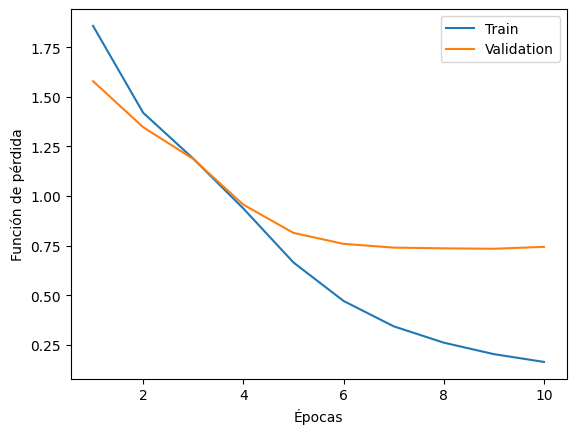

In [ ]:
plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses, label = 'Train')
plt.plot(range(1, len(val_losses)+1), val_losses, label = 'Validation')
plt.xlabel("Épocas")
plt.ylabel("Función de pérdida")
plt.legend()

#### Evaluación y traducción

In [ ]:
# Función para evaluar una oración
def evaluate(sentence):
    """
    Evalua una oración de entrada usando el modelo entrenado.

    Args:
      sentence: La oración de entrada.

    Returns:
      result: La oración traducida.
      sentence: La oración de entrada preprocesada.
      attention_plot: Una matriz de pesos de atención.
    """
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                            maxlen=max_length_inp,
                                                            padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

# Función para graficar los pesos de atención
def plot_attention(attention, sentence, predicted_sentence):
    """
    Grafica los pesos de atención.

    Args:
      attention: Matriz de pesos de atención.
      sentence: Oración de entrada.
      predicted_sentence: Oración traducida.
    """
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

# Función para traducir y mostrar la atención
def translate(sentence):
    """
    Traduce una oración de entrada y muestra la atención.

    Args:
      sentence: Oración de entrada.
    """
    result, sentence, attention_plot = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

# Restaurar el último checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> english is a extremely complex language , don t you think ? <end>
Predicted translation: es un viaje tan grande ? <end> 


<ipython-input-12-5f8e2217099d>:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-12-5f8e2217099d>:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


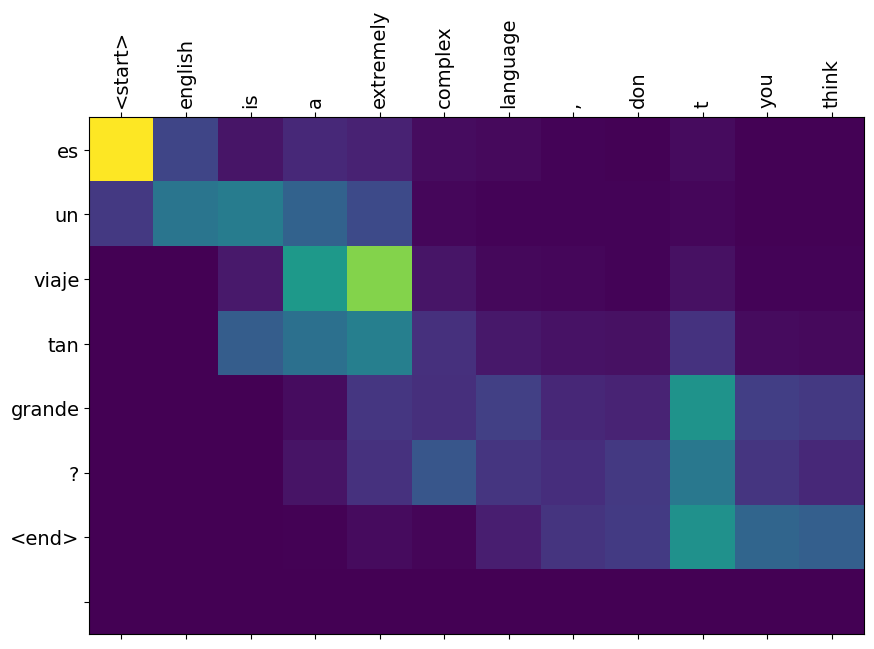

None
Input: <start> the day is warm and sunny <end>
Predicted translation: el dia esta caliente y un traidor . <end> 


<ipython-input-12-5f8e2217099d>:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-12-5f8e2217099d>:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


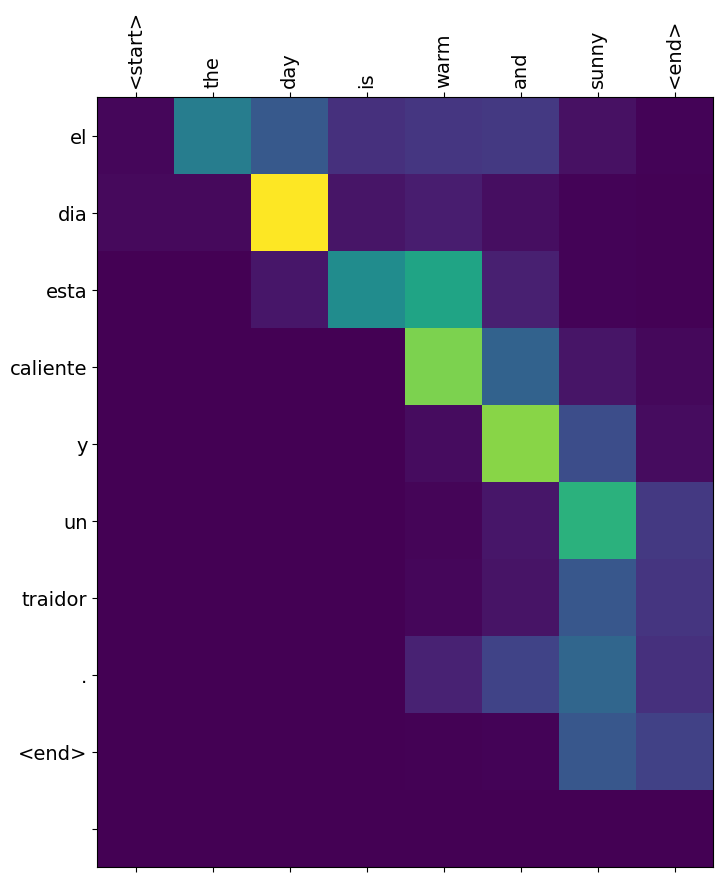

None
Input: <start> hello , nice to meet you . <end>
Predicted translation: hola bien de ti . <end> 


<ipython-input-12-5f8e2217099d>:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-12-5f8e2217099d>:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


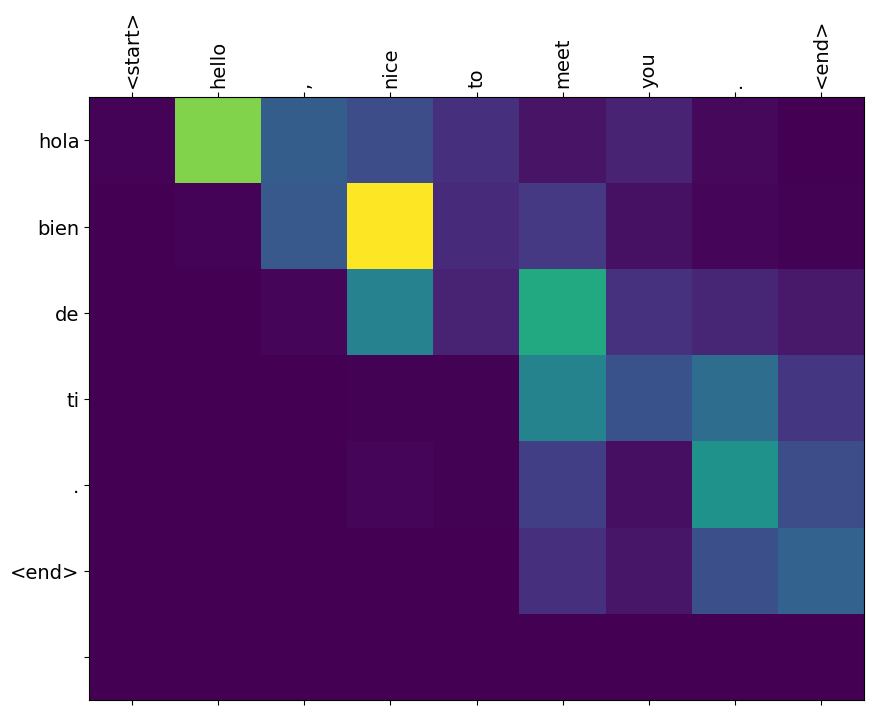

None
Input: <start> the cat is cute and lazy <end>
Predicted translation: el gato es bonito y blanco . <end> 


<ipython-input-12-5f8e2217099d>:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-12-5f8e2217099d>:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


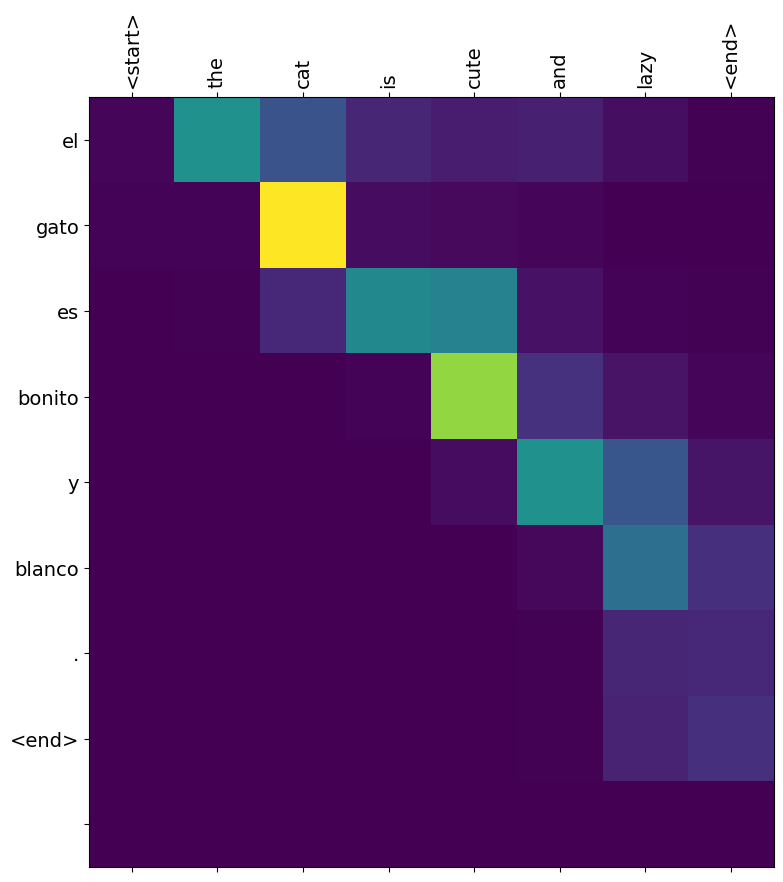

None
Input: <start> how are you ? <end>
Predicted translation: ¿ como estas ? <end> 


<ipython-input-12-5f8e2217099d>:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-12-5f8e2217099d>:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


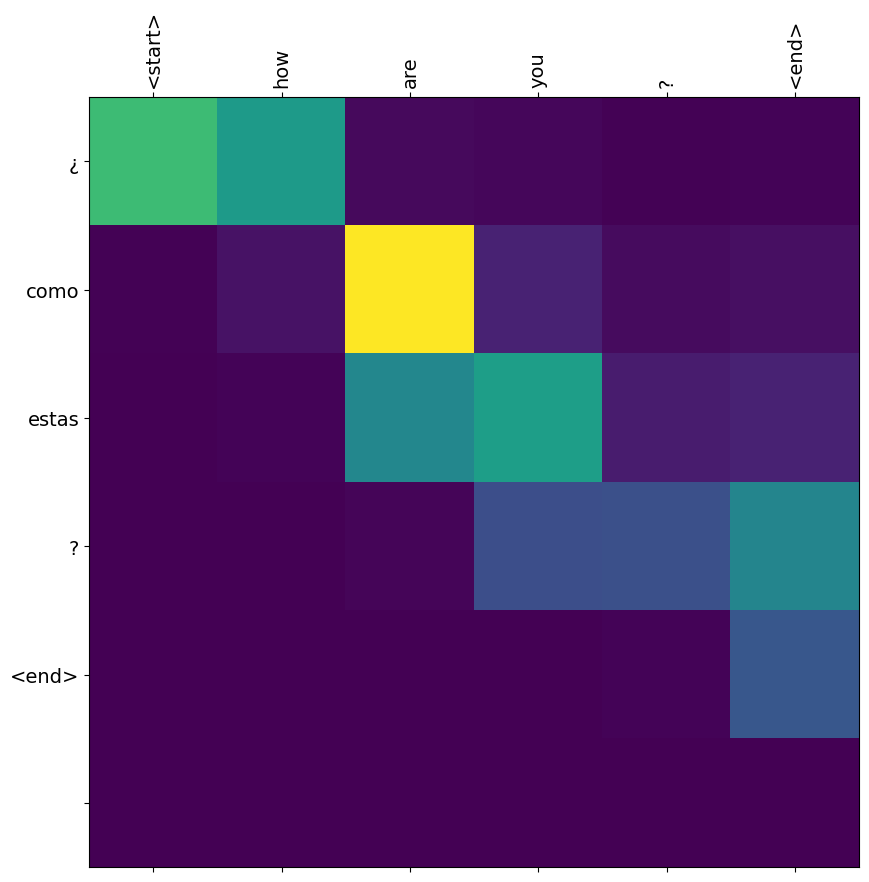

None
Input: <start> did you sleep well ? <end>
Predicted translation: ¿ percibiste algun buen ? <end> 


<ipython-input-12-5f8e2217099d>:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-12-5f8e2217099d>:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


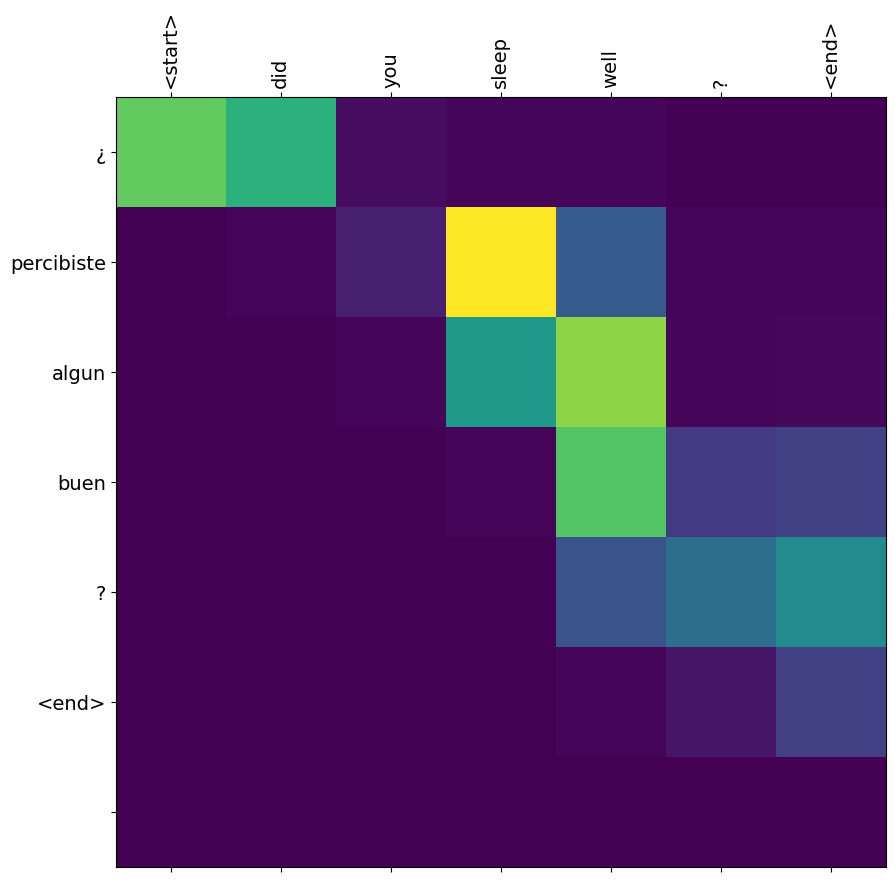

None
Input: <start> attention is all you need <end>
Predicted translation: la cena , tu necesitas . <end> 


<ipython-input-12-5f8e2217099d>:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-12-5f8e2217099d>:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


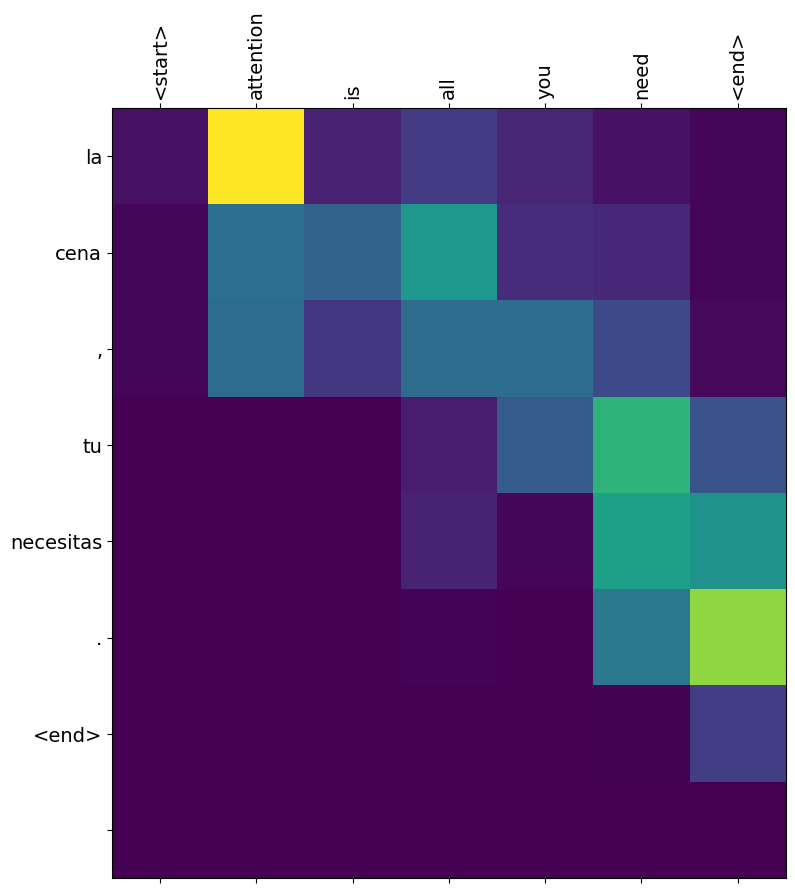

None
Input: <start> there is no future without the now , and right now we are learning about the future <end>
Predicted translation: ahora , ¿ estamos en el viaje conmigo el viaje conmigo el viaje conmigo el viaje 


<ipython-input-12-5f8e2217099d>:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-12-5f8e2217099d>:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


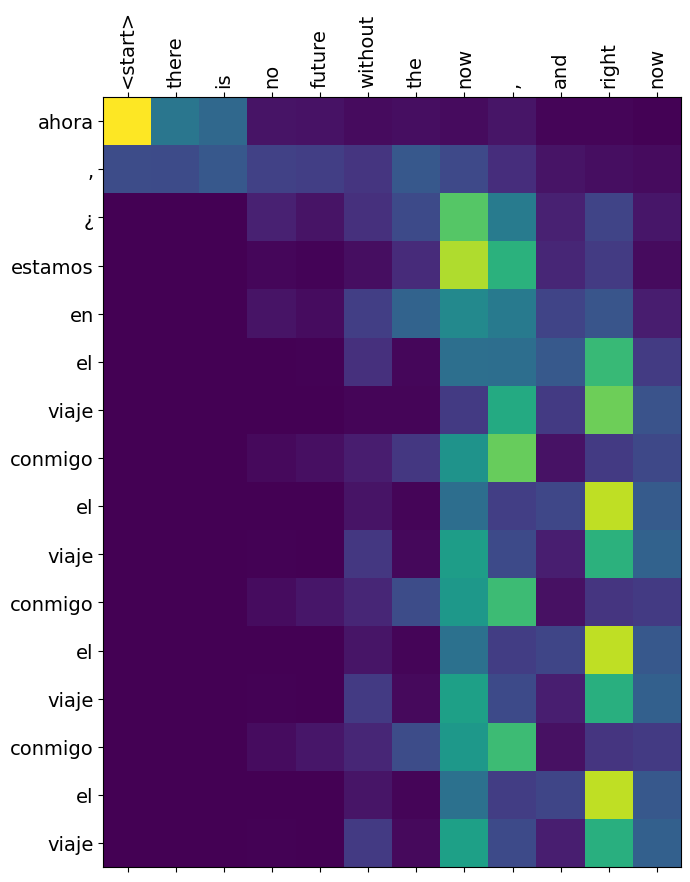

None


In [ ]:
print(translate("English is a extremely complex language, don't you think?"))
print(translate("the day is warm and sunny"))
print(translate("Hello, nice to meet you."))
print(translate("The cat is cute and lazy"))
print(translate("How are you?"))
print(translate("Did you sleep well?"))
print(translate("Attention is all you need"))
print(translate("There is no future without the now, and right now we are learning about the future"))

**Modelo con Atención Bahdanau**

- **Conclusión**: El modelo con atención Bahdanau, implementado con TensorFlow, muestra una capacidad de traducción "buena" con frases cortas, pero comete errores al procesar frases más complejas. Esto se debe a que es necsario modificar aún más la estructura del modelo y realizar ajustes con el entrenamiento.

### Modelo Transformer

#### Preparación de datos

Define el device para usar gpu

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Se cargan las secuencias inglés y español

In [ ]:
with open(path_to_file, 'r', encoding='utf-8') as file:
    lines = file.readlines()

source_texts = []
target_texts = []
for line in lines:
    parts = line.strip().split('\t')

    source_texts.append(parts[0])  # Inglés
    target_texts.append(parts[1])  # Español
len(target_texts)

141543

Se tokenizan las frases en inglés y español

Se fijan cuáles son los tokens especiales:

- unk: corresponde al token asignado para "desconocido"
- pad: token de padding. Alarga cada secuencia rellenando con este token hasta alcanzar el largo de la secuencia más larga presente en el dataset
- bos: token "beginning of sentence" corresponde al token de inicio de la secuencia
- eos: token "end of sentence" corresponde al token de fin de la secuencia


In [ ]:
# Crear el tokenizador WordLevel
source_tokenizer = Tokenizer(WordLevel(unk_token="<unk>"))
source_tokenizer.pre_tokenizer = Whitespace()
target_tokenizer = Tokenizer(WordLevel(unk_token="<unk>"))
target_tokenizer.pre_tokenizer = Whitespace()

# Entrenar el tokenizador
source_trainer = WordLevelTrainer(special_tokens=["<unk>", "<pad>", "<bos>", "<eos>"])
source_tokenizer.train_from_iterator(source_texts, trainer=source_trainer)

target_trainer = WordLevelTrainer(special_tokens=["<unk>", "<pad>", "<bos>", "<eos>"])
target_tokenizer.train_from_iterator(target_texts, trainer=target_trainer)

Se obtienen los vocabularios de inglés (source) y español (target). Corresponde a un diccionario donde cada key es un token y cada value es el id asignado

In [ ]:
source_vocab = source_tokenizer.get_vocab()
target_vocab = target_tokenizer.get_vocab()
reversed_tgt_vocab = {v: k for k, v in target_vocab.items()}
reversed_src_vocab = {v: k for k, v in source_vocab.items()}

In [ ]:
print(len(source_vocab))
print(len(target_vocab))

15838
30000


In [ ]:
source_sequences = [source_tokenizer.encode(text).ids for text in source_texts]
target_sequences = [target_tokenizer.encode(text).ids for text in target_texts]

Se agregan explícitamente los tokens especiales definidos anteriormente. Cada secuencia debe comenzar con 2 (bos) y terminar con 3 (eos)

In [ ]:
def add_special_tokens(sequence, bos_id, eos_id):
    """
    Agrega <bos> (inicio de secuencia) y <eos> (fin de secuencia) a una lista de índices.
    """
    return [bos_id] + sequence + [eos_id]

# IDs de los tokens especiales
bos_id_src = source_tokenizer.token_to_id("<bos>")
eos_id_src = source_tokenizer.token_to_id("<eos>")
bos_id_tgt = target_tokenizer.token_to_id("<bos>")
eos_id_tgt = target_tokenizer.token_to_id("<eos>")

# Aplicar tokens especiales a las secuencias
source_sequences = [add_special_tokens(source_tokenizer.encode(text).ids, bos_id_src, eos_id_src) for text in source_texts]
target_sequences = [add_special_tokens(target_tokenizer.encode(text).ids, bos_id_tgt, eos_id_tgt) for text in target_texts]

# Validar
print("Secuencia fuente con tokens especiales (primer ejemplo):", source_sequences[:1])
print("Secuencia destino con tokens especiales (primer ejemplo):", target_sequences[:1])

Secuencia fuente con tokens especiales (primer ejemplo): [[2, 622, 4, 3]]
Secuencia destino con tokens especiales (primer ejemplo): [[2, 1354, 4, 3]]


Guardar un 20% de las secuencias para validación

In [ ]:
src_train_sequences, src_val_sequences, tgt_train_sequences, tgt_val_sequences = train_test_split(
    source_sequences, target_sequences, test_size=0.2, random_state=42)

Definir datasets y dataloaders. Los dataloaders de training y validación corresponden a los iterables que espera el entrenamiento en Pytorch para recorrer el dataset por batches

Se agrega una función collate_fn que se encarga de rellenar con el token de padding

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, source_sequences, target_sequences):
        self.source_sequences = source_sequences
        self.target_sequences = target_sequences

    def __len__(self):
        return len(self.source_sequences)

    def __getitem__(self, idx):
        return self.source_sequences[idx], self.target_sequences[idx]

# Definir función de collate para manejar padding
def collate_fn(batch):
    source_batch, target_batch = zip(*batch)
    source_batch = pad_sequence(source_batch, batch_first=True, padding_value=1)
    target_batch = pad_sequence(target_batch, batch_first=True, padding_value=1)
    return source_batch, target_batch

# Convertir los datos en tensores
src_train_tensors = [torch.tensor(seq, dtype=torch.long) for seq in src_train_sequences]
src_val_tensors = [torch.tensor(seq, dtype=torch.long) for seq in src_val_sequences]
tgt_train_tensors = [torch.tensor(seq, dtype=torch.long) for seq in tgt_train_sequences]
tgt_val_tensors = [torch.tensor(seq, dtype=torch.long) for seq in tgt_val_sequences]

# Crear el dataset
train_dataset = TranslationDataset(src_train_tensors, tgt_train_tensors)
val_dataset = TranslationDataset(src_val_tensors, tgt_val_tensors)

# Crear el DataLoader
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: collate_fn(batch))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: collate_fn(batch))

#### Definición de modelos

Se define un modelo transformer, el cual contiene un mecanismo de Multi-head attention. Pytorch contiene un módulo en torch.nn.Transformer que encapsula toda la complejidad Encoder-Decoder + Multi-head Attention. Se añaden los embedding de ambos idiomas source y target, los cuales codifican las secuencias entrada a representaciones intermedia en dimensión d_model

In [ ]:
class CustomTransformer(nn.Module):
    """
    CustomTransformer
    implementa usando Pytorch un modelo Transformer
    """
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(CustomTransformer, self).__init__()
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.d_model = d_model

        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model, padding_idx = 1) # embedding ingles
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model, padding_idx = 1) # embedding español
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.transformer = nn.Transformer( # bloque transformer
            d_model=d_model,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 1).unsqueeze(1).unsqueeze(2) # 1 es padding
        tgt_mask = (tgt != 1).unsqueeze(1).unsqueeze(3) # 1 es padding
        seq_length = tgt.size(1)
        nopeak_mask = torch.triu(torch.ones(seq_length, seq_length), diagonal=1).bool().to(src.device)
        tgt_mask = nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None, tgt_mask=None):
        # Embedding + Positional Encoding
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        output = self.transformer(
            src_embedded,
            tgt_embedded,
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask,
            tgt_mask=tgt_mask
        )
        return self.fc(output)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(-torch.arange(0, d_model, 2).float() * (math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


#### Primera configuración

##### Entrenamiento de modelo

Definición de hiperparámetros

In [ ]:
# Hiperparámetros
src_vocab_size = len(source_vocab)
tgt_vocab_size = len(target_vocab)
embed_dim = 32
num_heads = 4
num_layers = 6
ff_dim = 128
max_seq_length = 100
dropout = 0.1

# Crear el modelo
model = CustomTransformer(
src_vocab_size, tgt_vocab_size, embed_dim, num_heads, num_layers, ff_dim, max_seq_length, dropout
).to(device)


Entrenamiento del modelo

se fija lr de 1e-3 y 30 épocas modificables en caso de encontrar overfitting

Epoch 1/30, Train Loss: 5.0458, Validation Loss: 4.2695
Epoch 2/30, Train Loss: 4.0661, Validation Loss: 3.7203
Epoch 3/30, Train Loss: 3.6061, Validation Loss: 3.3256
Epoch 4/30, Train Loss: 3.2371, Validation Loss: 2.9888
Epoch 5/30, Train Loss: 2.9316, Validation Loss: 2.7231
Epoch 6/30, Train Loss: 2.6843, Validation Loss: 2.5362
Epoch 7/30, Train Loss: 2.4867, Validation Loss: 2.3915
Epoch 8/30, Train Loss: 2.3335, Validation Loss: 2.2997
Epoch 9/30, Train Loss: 2.2053, Validation Loss: 2.2239
Epoch 10/30, Train Loss: 2.1001, Validation Loss: 2.1573
Epoch 11/30, Train Loss: 2.0110, Validation Loss: 2.1101
Epoch 12/30, Train Loss: 1.9330, Validation Loss: 2.0714
Epoch 13/30, Train Loss: 1.8657, Validation Loss: 2.0312
Epoch 14/30, Train Loss: 1.8073, Validation Loss: 2.0103
Epoch 15/30, Train Loss: 1.7544, Validation Loss: 1.9983
Epoch 16/30, Train Loss: 1.7081, Validation Loss: 1.9696
Epoch 17/30, Train Loss: 1.6653, Validation Loss: 1.9502
Epoch 18/30, Train Loss: 1.6292, Validat

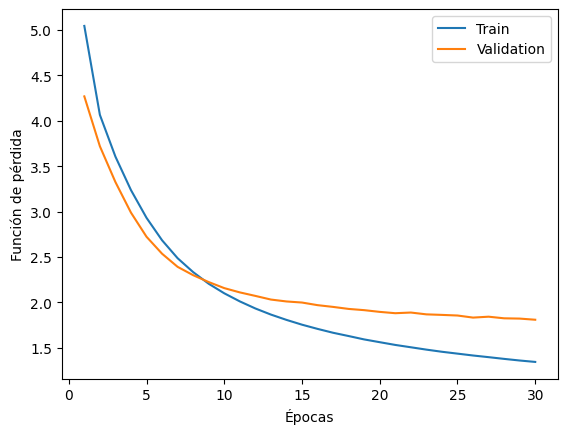

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=1)  # Ignorar <pad>
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 30

train_losses = []
val_losses = []
for epoch in range(epochs):

    train_epoch_loss = 0
    val_epoch_loss = 0

    model.train()
    for data in train_dataloader:
        src_data, tgt_data = data
        src_data = src_data.to(device)
        tgt_data = tgt_data.to(device)

        # Máscaras de padding
        src_key_padding_mask = (src_data == 1)
        tgt_key_padding_mask = (tgt_data[:, :-1] == 1)

        # Máscara causal (seq_length, seq_length)
        seq_length = tgt_data[:, :-1].size(1)
        tgt_mask = torch.triu(torch.ones(seq_length, seq_length, device=device), diagonal=1).bool()

        optimizer.zero_grad()
        output = model(
            src_data,
            tgt_data[:, :-1],
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            tgt_mask=tgt_mask
        )

        loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()/len(train_dataloader)


    model.eval()
    with torch.no_grad():
      for data in val_dataloader:
          src_data, tgt_data = data
          src_data = src_data.to(device)
          tgt_data = tgt_data.to(device)

          # Máscaras de padding
          src_key_padding_mask = (src_data == 1)
          tgt_key_padding_mask = (tgt_data[:, :-1] == 1)

          # Máscara causal (seq_length, seq_length)
          seq_length = tgt_data[:, :-1].size(1)
          tgt_mask = torch.triu(torch.ones(seq_length, seq_length, device=device), diagonal=1).bool()

          output = model(
              src_data,
              tgt_data[:, :-1],
              src_key_padding_mask=src_key_padding_mask,
              tgt_key_padding_mask=tgt_key_padding_mask,
              tgt_mask=tgt_mask
          )

          loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))

          val_epoch_loss += loss.item()/len(val_dataloader)

    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}")

plt.figure()
plt.plot(range(1, epochs+1), train_losses, label = 'Train')
plt.plot(range(1, epochs+1), val_losses, label = 'Validation')
plt.xlabel("Épocas")
plt.ylabel("Función de pérdida")
plt.legend()

##### Evaluación y traducción

Se define al igual que los modelos anteriores la función de traducción

IMPORTANTE: parte de la lógica de esta función es inspirada en la implementación disponible en https://github.com/shubhamprasad0/transformer-from-scratch/tree/main. Sin embargo, se le realizaron ajustes significativos para poder adaptarlo a este contexto.

In [16]:
def translate(src, max_seq_len=50):
    tgt_tokens = [""]
    src_vectors = [add_special_tokens(source_tokenizer.encode(src).ids, bos_id_src, eos_id_src)]
    src_vectors = torch.tensor(src_vectors).to(device)

    src_key_padding_mask = (src_vectors == 1)  # Padding es 1

    for i in range(max_seq_len): # generar token por token

        temp_chain = " ".join(tgt_tokens).strip()
        tgt_vectors = [add_special_tokens(target_tokenizer.encode(temp_chain).ids, bos_id_tgt, eos_id_tgt)]
        tgt_vectors = torch.tensor(tgt_vectors).to(device)

        seq_length = tgt_vectors.size(1)
        tgt_mask = torch.triu(torch.ones(seq_length, seq_length, device=device), diagonal=1).bool()

        tgt_key_padding_mask = (tgt_vectors == 1)

        with torch.no_grad():
          output = model(
              src_vectors,
              tgt_vectors,
              src_key_padding_mask=src_key_padding_mask,
              tgt_key_padding_mask=tgt_key_padding_mask,
              tgt_mask=tgt_mask
          )

          # Obtener el índice del token con la mayor probabilidad
          idx = torch.argmax(nn.functional.softmax(output, dim=2)[0, i]).item()

        if idx == target_tokenizer.token_to_id("<eos>"):  # Detener si encuentra fin de cadena
            break
        else:
            tgt_tokens.append(reversed_tgt_vocab.get(idx))

    return " ".join(tgt_tokens[1:]).strip()


Traducciones

In [17]:
print(translate("English is a extremely complex language, don't you think?"))
print(translate("the day is warm and sunny"))
print(translate("Hello, nice to meet you."))
print(translate("The cat is cute and lazy"))
print(translate("How are you?"))
print(translate("Did you sleep well?"))
print(translate("Attention is all you need"))
print(translate("With Transformers we can solve everything"))
print(translate("There is no future without the now, and right now we are learning about the future"))
print(translate("That's one small step for a man, one giant leap for mankind"))

¿ Por qué no has tan tan ?
El perro es el mundo .
Ellos me gusta , , por favor .
¿ Quién está la puerta .
¿ Qué te gusta ?
¿ Te gusta a la verdad ?
¿ Te has !
Me gusta lo que te te gusta .
Por favor , no hay en la puerta .
El libro es un día de la ciudad .


Se observan traducciones en general con más sentido gramático en relación al modelo de atención de Bahdanau. Pese a ello, en las últimas secuencias que son más largas comete varios errores introduciendo palabras que no tienen relación alguna

#### Segunda configuración

##### Entrenamiento de modelo

  Se aumenta la dimensión de embedding a 128 y la dimensión interna en encoder-decoder de 1024. También se aumentan las capas en encoder-decoder a 8

In [18]:
# Hiperparámetros
src_vocab_size = len(source_vocab)
tgt_vocab_size = len(target_vocab)
embed_dim = 128
num_heads = 4
num_layers = 6
ff_dim = 1024
max_seq_length = 100
dropout = 0.2

# Crear el modelo
model = CustomTransformer(
src_vocab_size, tgt_vocab_size, embed_dim, num_heads, num_layers, ff_dim, max_seq_length, dropout
).to(device)

se entrena por menos épocas debido que al aumentar los hiperparámetros el costo de entrenamiento se eleva excesivamente y Colab tiene límites de uso de GPU

Epoch 1/3, Train Loss: 5.4572, Validation Loss: 4.5572
Epoch 2/3, Train Loss: 4.4241, Validation Loss: 4.1039
Epoch 3/3, Train Loss: 4.1061, Validation Loss: 3.8423


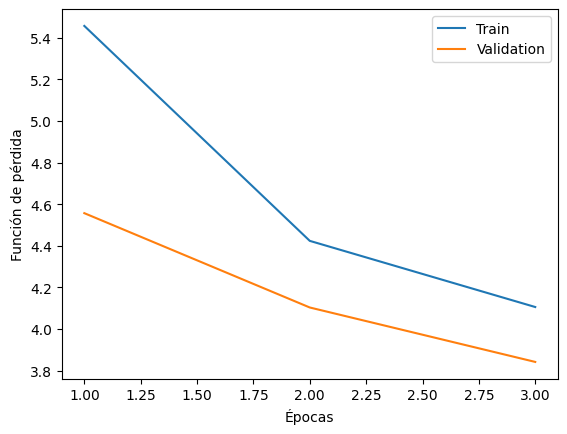

In [19]:
criterion = nn.CrossEntropyLoss(ignore_index=1)  # Ignorar <pad>
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)

epochs = 3

train_losses = []
val_losses = []
for epoch in range(epochs):

    train_epoch_loss = 0
    val_epoch_loss = 0

    model.train()
    for data in train_dataloader:
        src_data, tgt_data = data
        src_data = src_data.to(device)
        tgt_data = tgt_data.to(device)

        # Máscaras de padding
        src_key_padding_mask = (src_data == 1)
        tgt_key_padding_mask = (tgt_data[:, :-1] == 1)

        # Máscara causal (seq_length, seq_length)
        seq_length = tgt_data[:, :-1].size(1)
        tgt_mask = torch.triu(torch.ones(seq_length, seq_length, device=device), diagonal=1).bool()

        optimizer.zero_grad()
        output = model(
            src_data,
            tgt_data[:, :-1],
            src_key_padding_mask=src_key_padding_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            tgt_mask=tgt_mask
        )

        loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()/len(train_dataloader)


    model.eval()
    with torch.no_grad():
      for data in val_dataloader:
          src_data, tgt_data = data
          src_data = src_data.to(device)
          tgt_data = tgt_data.to(device)

          # Máscaras de padding
          src_key_padding_mask = (src_data == 1)
          tgt_key_padding_mask = (tgt_data[:, :-1] == 1)

          # Máscara causal (seq_length, seq_length)
          seq_length = tgt_data[:, :-1].size(1)
          tgt_mask = torch.triu(torch.ones(seq_length, seq_length, device=device), diagonal=1).bool()

          output = model(
              src_data,
              tgt_data[:, :-1],
              src_key_padding_mask=src_key_padding_mask,
              tgt_key_padding_mask=tgt_key_padding_mask,
              tgt_mask=tgt_mask
          )

          loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))

          val_epoch_loss += loss.item()/len(val_dataloader)

    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}")

plt.figure()
plt.plot(range(1, epochs+1), train_losses, label = 'Train')
plt.plot(range(1, epochs+1), val_losses, label = 'Validation')
plt.xlabel("Épocas")
plt.ylabel("Función de pérdida")
plt.legend()

##### Evaluación y traducción

In [20]:
print(translate("English is a extremely complex language, don't you think?"))
print(translate("the day is warm and sunny"))
print(translate("Hello, nice to meet you."))
print(translate("The cat is cute and lazy"))
print(translate("How are you?"))
print(translate("Did you sleep well?"))
print(translate("Attention is all you need"))
print(translate("With Transformers we can solve everything"))
print(translate("There is no future without the now, and right now we are learning about the future"))
print(translate("That's one small step for a man, one giant leap for mankind"))

¿ Por qué es un libro , pero no es un libro ?
El padre es la puerta y la puerta .
Si te gusta la verdad .
El padre es un libro .
¿ Qué estás ?
¿ Te gusta la noche ?
¿ Qué es más que te es aquí .
La casa no puede hacer nada .
No es la casa , pero es la casa , pero no es la noche .
Eso es un poco de un poco , pero es un poco de un poco de un poco de un poco de un poco , pero no es muy muy muy muy muy poco .


## Análisis de resultados

El modelo Transformer, implementado con PyTorch, destaca por su rendimiento y calidad de traducción por sobre el modelo con atención simple de Bahdanau. En general, se pudo observar que en las secuencias más largas logra capturar de mejor manera el "contexto" de cada palabra, lo cual permite una traducción final con más sentido. Sin embargo, se pudo observar en varias secuencias que aún **le es dificultuoso traducir** en varias secuencias como por ejemplo las siguientes traducciones para las frases "Attention is all you need" y
"There is no future without the now, and right now we are learning about the future"
- Asociamos que podemos resolver todo el sonido .
- Ahora no hay futuro sin la mejor ahora , ahora estamos en el futuro .

Tiene varias palabras sin sentido y existe espacio de mejora con mejores embeddings de palabras, pero tienen sentido gramatical. Sin embargo, si se comparan con el modelo de atención de Bahdanau

- la cena , tu necesitas .
- ahora , ¿ estamos en el viaje conmigo el viaje conmigo el viaje conmigo el viaje

se puede observar que este último no es capaz de capturar la dinámica, el contexto de cada palabra por lo cual la segunda frase no solo introduce palabras incorrectas, sino que no tiene sentido gramatical en español, incluso repite palabras


Pese a esto, en estas secuencias se tiene una traducción de mejor calidad que en el modelo con atención simple Bahdanau.

La arquitectura basada en la atención multi-cabeza le permite capturar relaciones complejas entre palabras y generar traducciones más precisas y naturales. Además, su capacidad para procesar información en paralelo lo hace significativamente más rápido que los modelos anteriores.

## Conclusión General

Se puede concluir que el modelo Transformer, con su arquitectura basada en la atención multi-cabeza, se destacó como el más avanzado y con mejor rendimiento, generando traducciones de mejor calidad frente a un modelo de atención simple de Bahdanau.

Se concluye un cumplimiento de los objetivos, ya que se pudo ver en acción el mecanismo de atención multicabeza y cómo este destaca en generar mejores traducciones inglés-español. Sin embargo, aún existe espacio de mejora para poder generar traducciones altamente robustas y de alta calidad. Con este propósito se propone un entrenamiento con vocabularios más grandes en ambos idiomas y usar embeddings de palabras pre-entrenados, lo cual permite una mejor representación de cada palabra.